# Handbook of Anomaly Detection: With Python Outlier Detection KNN

https://archive.is/UJdqg#selection-603.0-603.564

El algoritmo de los k vecinos más cercanos, conocido como KNN o k-NN, es probablemente uno de los algoritmos más populares en el aprendizaje automático. Los KNN se utilizan normalmente como una técnica de aprendizaje supervisado en la que se proporcionan las etiquetas de destino. Los KNN también se pueden utilizar para el cálculo de la distancia a los k vecinos. Debido a que este último no utiliza una variable de destino, algunas fuentes en línea como el KNN de scikit-learn [1] lo denominan aprendizaje no supervisado. El KNN en PyOD utiliza este último. Calcula la distancia a los k vecinos y utiliza la distancia para definir las puntuaciones de los valores atípicos.

Al principio del capítulo, dedicaré un espacio a aclarar cómo se puede utilizar KNN en un aprendizaje supervisado o no supervisado. Luego, explicaré cómo KNN define la puntuación de valores atípicos para la detección de anomalías.

## (A) Utilice KNN como técnica de aprendizaje no supervisado

El método k-NN no supervisado calcula la distancia euclidiana de la observación con respecto a otras observaciones. El método KNN no supervisado no tiene parámetros que ajustar para mejorar el rendimiento. Simplemente calcula las distancias entre los vecinos. Realiza los siguientes pasos:

- Paso 1: Para cada punto de datos, calcula la distancia a otros puntos de datos.
- Paso 2: Ordena los puntos de datos del más pequeño al más grande según la distancia.
- Paso 3: Selecciona las primeras K entradas.

Existen varias opciones para calcular la distancia entre dos puntos de datos. La más popular es la distancia euclidiana.

## (B) Utilice KNN como técnica de aprendizaje supervisado

El algoritmo KNN se utiliza ampliamente como algoritmo de clasificación en un entorno de aprendizaje supervisado. Se utiliza para predecir la clase de un nuevo punto de datos. Supone que los puntos de datos similares de la misma clase suelen estar cerca unos de otros.

La figura (B) muestra los puntos de datos con la clase azul y la clase roja. Si hay un nuevo punto de datos, ¿cuál debería ser la clase para el nuevo punto de datos? El algoritmo calcula las distancias de este punto de datos a otros puntos de datos. Para los 5 vecinos más cercanos, cuenta la cantidad de clases azul y roja. En el gráfico, hay 4 clases rojas y 1 clase azul. El algoritmo utiliza la regla de votación por mayoría para determinar la clase. Al nuevo punto de datos se le asigna la clase roja.

![figura_b](images/figura_b.png)

El procedimiento se puede enumerar de la siguiente manera. Además de los pasos 1 a 3 anteriores, la red neuronal conmutada supervisada realiza los pasos 4 y 5:

- Paso 4: Entre estos K vecinos, cuente la cantidad de clases.
- Paso 5: Asigne el nuevo punto de datos a la clase mayoritaria.

## (C) ¿Cómo se define la puntuación de anomalía?

Dado que un valor atípico es un punto que está alejado de los puntos vecinos, la puntuación del valor atípico se define como la distancia a su k-ésimo vecino más cercano. Cada punto tendrá una puntuación atípica. Nuestro trabajo es encontrar aquellos puntos con puntuaciones atípicas altas.

El método KNN en PyOD utiliza uno de los tres tipos de medidas de distancia como puntuación del valor atípico: mayor (predeterminado), media y mediana. El “mayor” utiliza la mayor distancia a los k vecinos como puntuación del valor atípico. La “media” y la “mediana” utilizan el promedio y la mediana respectivamente como puntuación del valor atípico.

## (D) Procedimiento de modelado

Aplico el siguiente procedimiento de modelado para el desarrollo del modelo, la evaluación y la interpretación de los resultados.

- Desarrollo del modelo
- Determinación del umbral
- Estadísticas descriptivas de los grupos normales y anormales

![pasos](images/pasos.png)

En el paso 1, se creará el modelo y se obtendrán los puntajes atípicos. En el paso 2, se elegirá un umbral para separar las observaciones anormales con puntajes atípicos altos de las observaciones normales. Si algún conocimiento previo sugiere que el porcentaje de anomalías no debe ser mayor del 1 %, se puede elegir un umbral que dé como resultado aproximadamente el 1 % de anomalías.

En el paso 3, se perfilarán los dos grupos utilizando las estadísticas descriptivas (como las medias y las desviaciones estándar) por grupo. La tabla de estadísticas descriptivas es importante para comunicar la solidez del modelo. Si se espera que la media de una característica en el grupo anormal sea mayor que la del grupo normal y el resultado es contraintuitivo, se deberá investigar, modificar o descartar la característica. Se deberán repetir los pasos 1 a 3 hasta que las estadísticas descriptivas de todas las características sean consistentes con las expectativas.

### (D.1) Paso 1: Construye tu modelo

Generemos algunos datos con valores atípicos. Utilizo la función de utilidad generate_data() de PyOD y genero un diez por ciento de valores atípicos. Observe que, aunque este conjunto de datos simulado tiene la variable de destino Y, los modelos KNN no supervisados ​​solo utilizan las variables X. La variable Y es simplemente para validación.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from pyod.models.knn import KNN
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer

In [3]:
contamination = 0.05 # percentage of outliers
n_train = 500       # number of training points
n_test = 500        # number of testing points
n_features = 6      # number of features
X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train, 
    n_test=n_test, 
    n_features= n_features, 
    contamination=contamination, 
    random_state=123)

In [5]:
# Make the 2d numpy array a pandas dataframe for each manipulation 
X_train_pd = pd.DataFrame(X_train)

Los puntos amarillos del diagrama de dispersión son el diez por ciento de los valores atípicos. Las observaciones “normales” son los puntos morados.

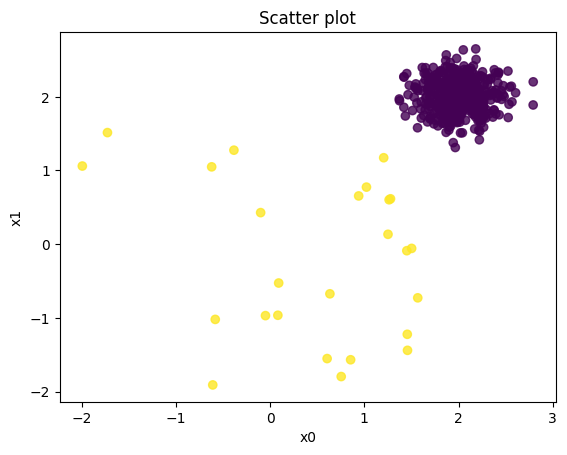

In [6]:
# Plot
plt.scatter(X_train_pd[0], X_train_pd[1], c=y_train, alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

El código siguiente realiza el cálculo para el modelo k-NN y lo almacena como knn. Observe que no hay y en la función .fit(). Esto se debe a que y se ignora en los métodos no supervisados. def fit(self, X, y=None). Si se especifica y, se convierte en un método supervisado.

El código siguiente crea el modelo y puntúa los datos de entrenamiento y prueba. Repasemos cada línea:

- label_: Este es el vector de etiquetas para los datos de entrenamiento. Es lo mismo si usa .predict() en los datos de entrenamiento.
- decision_scores_: Este es el vector de puntaje para los datos de entrenamiento. Es lo mismo si usa decision_functions() en los datos de entrenamiento.
- decisoin_score(): Esta función de puntaje asigna el puntaje de valor atípico a cada observación.
- predict(): Esta es la función de predicción que asigna 1 o 0 según el umbral asignado.
- pollution: Este es el porcentaje de valores atípicos. En la mayoría de los casos, no conocemos el porcentaje de valores atípicos, por lo que podemos asignar un valor en función de cualquier conocimiento previo. PyOD establece la tasa de contaminación en un 10 % de manera predeterminada. Este parámetro no afecta el cálculo de los puntajes de valores atípicos.

In [8]:
knn = KNN(contamination=0.05) 
knn.fit(X_train)

KNN(algorithm='auto', contamination=0.05, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [9]:
# Training data
y_train_scores = knn.decision_function(X_train)
y_train_pred = knn.predict(X_train)

In [10]:
# Test data
y_test_scores = knn.decision_function(X_test)
y_test_pred = knn.predict(X_test) # outlier labels (0 or 1)

In [11]:
def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The training data:", count_stat(y_test_pred))
# Threshold for the defined comtanimation rate
print("The threshold for the defined comtanimation rate:" , knn.threshold_)

The training data: {0: 475, 1: 25}
The training data: {0: 475, 1: 25}
The threshold for the defined comtanimation rate: 0.7566127656515499


Veamos los parámetros predeterminados de KNN usando .get_params(). El número de vecinos es 5,0. La tasa de contaminación se establece en 5 %.

In [12]:
knn.get_params()

{'algorithm': 'auto',
 'contamination': 0.05,
 'leaf_size': 30,
 'method': 'largest',
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': 1,
 'n_neighbors': 5,
 'p': 2,
 'radius': 1.0}

### (D.2) Paso 2: Determinar un umbral razonable

En la mayoría de los casos, no conocemos el porcentaje de valores atípicos. Podemos utilizar el histograma de la puntuación de valores atípicos para seleccionar un umbral razonable. Si hay algún conocimiento previo que sugiera que las anomalías son del 1 %, debe elegir un umbral que dé como resultado aproximadamente el 1 % de anomalías. El histograma de la puntuación de valores atípicos en la Figura (D.2) sugiere un umbral de 200,0 porque hay un corte natural en el histograma. La mayoría de los puntos de datos tienen puntuaciones de anomalías bajas. Si elegimos 1,0 como punto de corte, podemos sugerir que aquellos valores >=1,0 son valores atípicos.

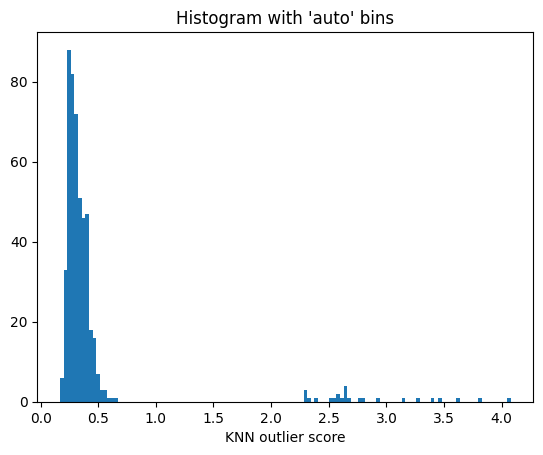

In [15]:
plt.hist(y_train_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.xlabel('KNN outlier score')
plt.show()

### (D.3) Paso 3: Perfilar los grupos normales y anormales

La elaboración de perfiles de los grupos normales y atípicos es un paso fundamental para demostrar la solidez de un modelo. Las estadísticas de las características de los grupos normales y anormales deben ser coherentes con cualquier conocimiento del dominio. Si la media de una característica en el grupo anormal debe ser alta pero el resultado es el opuesto, se recomienda examinar, modificar o descartar la característica. Debe iterar el proceso de modelado hasta que todas las características sean coherentes con el conocimiento previo. Por otro lado, también se recomienda verificar el conocimiento previo si los datos proporcionan nuevos conocimientos.

In [18]:
threshold = knn.threshold_ # Or other value from the above histogram

In [19]:
def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,475,95.0,2.00,2.01,2.01,1.99,2.01,1.98,0.32
1,Outlier,25,5.0,0.45,-0.21,-0.47,-0.23,-0.03,-0.06,2.84


La tabla anterior presenta las características de los grupos normales y anormales. Muestra el recuento y el porcentaje de recuento de los grupos normales y atípicos. Se le recuerda que debe etiquetar las características con sus nombres para una presentación eficaz. La tabla nos indica varios resultados importantes:

- El tamaño del grupo de valores atípicos: una vez que se determina un umbral, se determina el tamaño. Si el umbral se deriva de la Figura (D.2) y no hay conocimiento previo, la estadística de tamaño se convierte en una buena referencia para comenzar.
- Las estadísticas de características en cada grupo: todas las medias deben ser consistentes con el conocimiento del dominio. En nuestro caso, las medias en el grupo de valores atípicos son más pequeñas que las del grupo normal.
- La puntuación promedio de anomalías: la puntuación promedio del grupo de valores atípicos debe ser más alta que la del grupo normal. No es necesario interpretar demasiado las puntuaciones.

Como tenemos la verdad básica en la generación de datos, podemos generar una matriz de confusión para comprender el rendimiento del modelo. El modelo realiza un trabajo aceptable e identifica los 25 valores atípicos.

In [20]:
Actual_pred = pd.DataFrame({'Actual': y_test, 'Anomaly_Score': y_test_scores})
Actual_pred['Pred'] = np.where(Actual_pred['Anomaly_Score']< threshold,0,1)
pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])

Pred,0,1
Actual,,
0.0,475,0
1.0,0,25


## (E) Lograr la estabilidad del modelo mediante la agregación de múltiples modelos

Las KNN pueden ser sensibles a la elección de k. Para producir un modelo con un resultado estable, la mejor práctica es construir múltiples modelos KNN y luego agregar las puntuaciones. Este enfoque reducirá la posibilidad de sobreajuste y aumentará la precisión de la predicción.

El módulo PyOD ofrece cuatro métodos para agregar el resultado. Solo necesita usar un método para generar el resultado agregado.

- Promedio
- Máximo del máximo (MOM)
- Promedio del máximo (AOM)
- Máximo del promedio (MOA)

Crearé 20 modelos KNN para un rango de k vecinos de 10 a 200.

In [24]:
# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)
# Test a range of k-neighbors from 10 to 200. There will be 20 k-NN models.
k_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
n_clf = len(k_list)
# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])
train_scores.shape

(500, 20)

In [25]:
# Modeling
for i in range(n_clf):
    k = k_list[i]
    clf = KNN(n_neighbors=k, method='largest')
    clf.fit(X_train_norm)

    # Store the results in each column:
    train_scores[:, i] = clf.decision_scores_
    test_scores[:, i] = clf.decision_function(X_test_norm) 
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

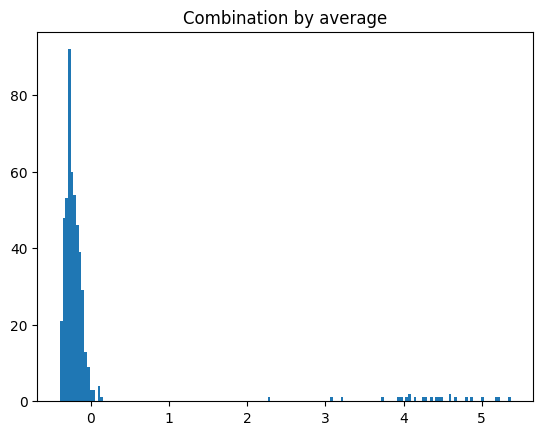

In [28]:
# Combination by average
# The test_scores_norm is 500 x 10. The "average" function will take the average of the 10 columns. 
# The result "y_by_average" is a single column: 
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)

plt.hist(y_train_by_average, bins='auto') # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

La figura (E) muestra que la mayoría de los datos están por debajo de 0,0. Hay algunos valores atípicos en torno a 1,0. Probablemente tenga sentido establecer el umbral en 1,0 o incluso en 2,0. Con eso, podemos perfilar los grupos normales y atípicos. Las estadísticas descriptivas se muestran en la tabla (E). Identifica 25 puntos de datos como valores atípicos. Y las medias de las características del grupo de valores atípicos son todas más pequeñas que las del grupo normal. Esto es coherente con los resultados de la tabla (D.3).

In [30]:
descriptive_stat_threshold(X_train,y_train_by_average, 0.5)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,475,95.0,2.00,2.01,2.01,1.99,2.01,1.98,-0.23
1,Outlier,25,5.0,0.45,-0.21,-0.47,-0.23,-0.03,-0.06,4.28


## (F) Resumen

El método k-NN no supervisado calcula la distancia euclidiana de la observación con respecto a otras observaciones. El KNN no supervisado no tiene ningún parámetro que ajustar para mejorar el rendimiento. Simplemente calcula las distancias entre vecinos.

La puntuación de valores atípicos del KNN se define como la distancia a su k-ésimo vecino más cercano.

https://github.com/dataman-git/codes_for_articles/blob/master/08.%20KNN.ipynb


## Apéndice: ¿Cuáles son las “distancias” en kNN y k-Means?

kNN encuentra la distancia a los vecinos más cercanos, y k-Means encuentra la distancia al centroide de un grupo.

La biblioteca Scikit-learn incluye el algoritmo kNN supervisado (consulte 1.6.1 Vecinos más cercanos no supervisados) y el algoritmo K-means. Voy a utilizar solo los cinco puntos de datos principales de nuestros datos para mostrarle las diferencias.

In [33]:
samples = X_train[0:5]
samples

array([[2.39609016, 2.09261116, 2.07339234, 1.98826161, 1.95347251,
        2.45099742],
       [1.63104013, 1.74618159, 1.89804998, 2.38014773, 1.96733237,
        1.85891645],
       [1.82468347, 2.13141242, 2.02882911, 1.70345385, 2.50296555,
        2.11910763],
       [2.10609783, 2.16517299, 2.34082625, 2.17010947, 1.74913891,
        1.67866082],
       [1.82964656, 1.77559648, 1.82943754, 2.05476803, 1.57719031,
        1.59454864]])

### (F.1) k-NN:

La k-NN no supervisada calcula la distancia de un punto a su punto de datos más cercano. Por ejemplo, el punto más cercano del punto "0" (observe que Numpy etiqueta los cinco puntos como [0,1,2,3,4]) es el punto 4 y la distancia es 0,72002248.

In [34]:
my_knn = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(samples)
distances, indices = my_knn.kneighbors(samples, return_distance=True)
distances

array([[0.        , 0.90730696],
       [0.        , 0.61072952],
       [0.        , 0.90730696],
       [0.        , 0.73461446],
       [0.        , 0.61072952]])

In [35]:
indices

array([[0, 2],
       [1, 4],
       [2, 0],
       [3, 4],
       [4, 1]], dtype=int64)

### (F.2) k-means:

Cuando se especifica que habrá N grupos, el método k-Means comienza con N semillas elegidas aleatoriamente. Calcula la distancia de cada punto de datos a esas N semillas. Luego, k-means asigna cada punto de datos a la semilla más cercana para formar un grupo. Esto agrupará los puntos de datos en N grupos. Luego, k-means actualiza la ubicación de cada semilla con el centroide del grupo, por lo que la semilla es el centroide del grupo. Este proceso se repetirá hasta que los valores de los centroides se estabilicen.

In [37]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(samples)
kmeans.labels_

array([0, 1, 0, 1, 1])

El resultado anterior muestra los grupos de los cinco puntos. Y el resultado siguiente muestra las ubicaciones de los centroides en los dos grupos.

In [38]:
centroids = kmeans.cluster_centers_
centroids

array([[2.11038681, 2.11201179, 2.05111073, 1.84585773, 2.22821903,
        2.28505252],
       [1.85559484, 1.89565035, 2.02277126, 2.20167508, 1.76455386,
        1.71070864]])